In [6]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns


In [2]:
# df1 = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\score_full.csv')
# df2 = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\score_title.csv')
# df3 = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\score_content.csv')

df1 = pd.read_csv(r'C:\Users\boyu571\boyu571_Github\01_Kakaobank_SKKU_Research_23\data\sentiment_score\score_full.csv')
df2 = pd.read_csv(r'C:\Users\boyu571\boyu571_Github\01_Kakaobank_SKKU_Research_23\data\sentiment_score\score_title.csv')
df3 = pd.read_csv(r'C:\Users\boyu571\boyu571_Github\01_Kakaobank_SKKU_Research_23\data\sentiment_score\score_content.csv')

In [19]:
# 마지막 열의 값이 9999인 행에서 해당 값을 NaN으로 설정
df1.loc[df1['score2'] == 9999, 'score2'] = np.nan
df3.loc[df3['score_content2'] == 9999, 'score_content2'] = np.nan
df3[df3['score_content2'] > 1] = np.nan

In [18]:
df3[df3['score_content2'] > 1]

,UTC-date,UTC-time,title,content,press,link,score_content,score_content2
4661,2018-10-15,2018-10-15 00:02:00,[경제·금융 상식 퀴즈 O X] 10월 15일<610>,\r1. 기업이 블록체인 기반의 코인을 발행한 뒤 이를 투자자에게 판매해 자금을 확...,한국경제,https://n.news.naver.com/mnews/article/015/000...,1. 4\n2. 2\n3. 1\n4. 2\n5. 1\n6. 3\n7. 4\n8. 1,2.250
15589,2022-01-28,2022-01-28 05:31:01,[경제·금융 상식 퀴즈 O X] 1월 24일 (739),1. 사업계획을 담은 백서(白書)를 공개한 후 새로운 암호화폐를 발행해 투자자들로부...,한국경제,https://n.news.naver.com/mnews/article/015/000...,1. 1\n2. -1\n3. 4\n4. 1\n5. 4\n6. 1\n7. 4\n8. 3,2.125
16544,2022-04-13,2022-04-13 01:02:08,[경제·금융 상식 퀴즈 O X] 4월 11일 (749),"1. 최대 2100만 개를 발행하도록 설계된 암호화폐로, 익명의 개발자 사토시 나카...",한국경제,https://n.news.naver.com/mnews/article/015/000...,1. 1\n2. 4\n3. 3\n4. 2\n5. 3\n6. 2\n7. 3\n8. 3,2.625


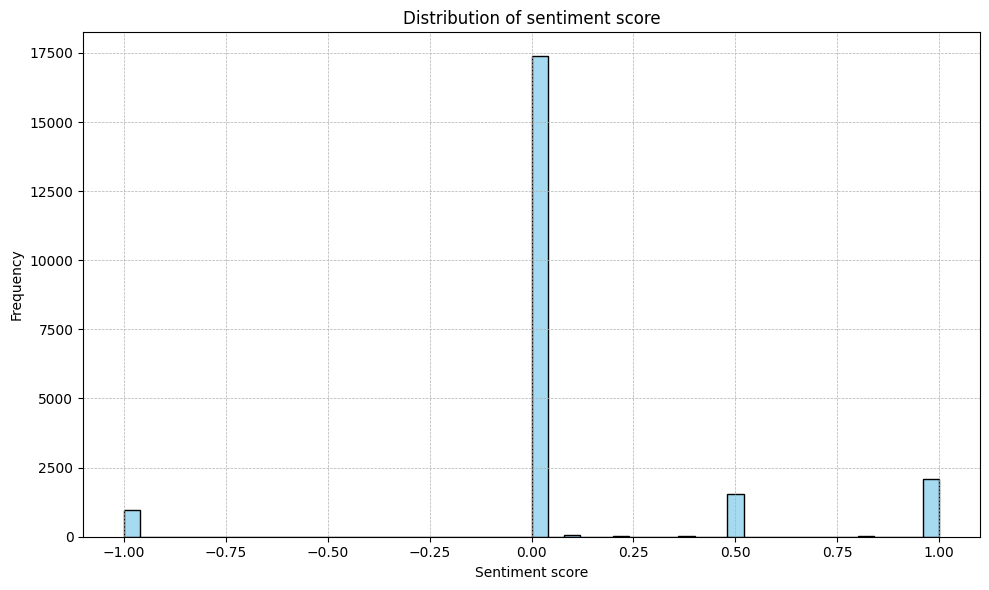

In [20]:
# Plotting the distribution of 'score2'
plt.figure(figsize=(10, 6))
sns.histplot(df3['score_content2'], bins=50, color='skyblue')
plt.title('Distribution of sentiment score')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

In [36]:
df3[df3['score_content2']==0].count()

UTC-date          17374
UTC-time          17374
title             17374
content           17374
press             17374
link              17374
score_content     17374
score_content2    17374
dtype: int64

In [31]:
# Removing NaN values from the 'score_content2' column
cleaned_data = df1['score2'].dropna()

# Performing the Shapiro-Wilk test for normality on cleaned data
stat_cleaned, p_value_cleaned = shapiro(cleaned_data)

stat_cleaned, p_value_cleaned

c:\Users\boyu571\anaconda3\envs\commons\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6685258746147156, 0.0)

In [30]:
score_stats = df1['score2'].describe()
score_title_stats = df2['score_title2'].describe()
score_content_stats = df3['score_content2'].describe()
comparison_df = pd.concat([score_stats, score_title_stats, score_content_stats], axis=1, keys=['score', 'score_title', 'score_content'])

comparison_df= comparison_df.round(4)
print(comparison_df)
comparison_df.to_csv('통계.csv')

            score  score_title  score_content
count  22185.0000   22209.0000     22165.0000
mean       0.0997       0.0693         0.0890
std        0.4734       0.5265         0.3851
min       -1.0000      -1.0000        -1.0000
25%        0.0000       0.0000         0.0000
50%        0.0000       0.0000         0.0000
75%        0.0000       0.5000         0.0000
max        1.0000       1.0000         1.0000


In [4]:
grouped_df1 = df1.groupby('UTC-date')['score2'].mean().reset_index()
grouped_df1 = grouped_df1.rename(columns={'UTC-date': 'date', 'score2':'score_full'})

grouped_df2 = df2.groupby('UTC-date')['score_title2'].mean().reset_index()
grouped_df2 = grouped_df2.rename(columns={'UTC-date': 'date', 'score_title2':'score_title'})

grouped_df3 = df3.groupby('UTC-date')['score_content2'].mean().reset_index()
grouped_df3 = grouped_df3.rename(columns={'UTC-date': 'date', 'score_content2':'score_content'})

# 'date' 컬럼을 기준으로 outer join
merged_df = grouped_df1.merge(grouped_df2, on='date').merge(grouped_df3, on='date')
merged_df = merged_df.drop(0)
merged_df.reset_index(drop=True, inplace=True)

In [5]:
data = merged_df

In [61]:
data

,date,score_full,score_title,score_content
0,2017-01-01,0.000000,0.250000,0.000000
1,2017-01-02,0.200000,-0.200000,0.000000
2,2017-01-03,0.500000,0.625000,0.750000
3,2017-01-04,0.200000,0.000000,0.200000
4,2017-01-05,0.000000,0.000000,0.000000
...,...,...,...,...
2425,2023-08-26,0.333333,0.333333,0.000000
2426,2023-08-27,-0.250000,0.125000,-0.250000
2427,2023-08-28,0.000000,0.153846,0.000000
2428,2023-08-29,-0.062500,0.250000,0.062500


In [23]:
score_stats = data['score_full'].describe()
score_title_stats = data['score_title'].describe()
score_content_stats = data['score_content'].describe()

In [24]:
comparison_df = pd.concat([score_stats, score_title_stats, score_content_stats], axis=1, keys=['score', 'score_title', 'score_content'])
print(comparison_df)

             score  score_title  score_content
count  2430.000000  2430.000000    2430.000000
mean      0.102129     0.066674       0.091520
std       0.230088     0.241891       0.181490
min      -1.000000    -1.000000      -1.000000
25%       0.000000    -0.051974       0.000000
50%       0.075962     0.062500       0.071429
75%       0.230769     0.205882       0.181818
max       1.000000     1.000000       1.000000


In [51]:
time_series_1 = data['score_full']
time_series_2 = data['score_title']
time_series_3 = data['score_content']

# Calculate statistics for each time series
data = []
time_series_list = [time_series_1, time_series_2, time_series_3]
for ts in time_series_list:
    mean = round(np.mean(ts), 3)
    std_dev = round(np.std(ts), 3)
    skewness = round(pd.Series(ts).skew(), 3)
    kurtosis = round(pd.Series(ts).kurtosis(), 3)
    first_order_auto_corr = round(pd.Series(ts).autocorr(lag=1), 3)
    
    # Cross-correlations with other time series
    cross_corr_1 = round(pd.Series(ts).corr(pd.Series(time_series_1)), 3)
    cross_corr_2 = round(pd.Series(ts).corr(pd.Series(time_series_2)), 3)
    cross_corr_3 = round(pd.Series(ts).corr(pd.Series(time_series_3)), 3)
    
    data.append([mean, std_dev, skewness, kurtosis, first_order_auto_corr, cross_corr_1, cross_corr_2, cross_corr_3])

# Create a DataFrame
df = pd.DataFrame(data, 
                  columns=['Mean', 'Std.Dev.', 'Skewness', 'Kurtosis', 'First-Order Auto correlation', 'cross-correlation(1)', 'cross-correlation(2)', 'cross-correlation(3)'], 
                  index=['Title + Content', 'Title', 'Content'])
df

,Mean,Std.Dev.,Skewness,Kurtosis,First-Order Auto correlation,cross-correlation(1),cross-correlation(2),cross-correlation(3)
Title + Content,0.102,0.230,0.088,2.498,0.251,1.000,0.664,0.740
Title,0.067,0.242,-0.284,2.060,0.216,0.664,1.000,0.591
Content,0.092,0.181,0.279,3.562,0.250,0.740,0.591,1.000


In [6]:
df.to_csv('result.csv')

NameError: name 'df' is not defined

In [7]:
bitcoin = pd.read_csv('bitcoin_krw.csv', index_col=0)
bitcoin['date'] = pd.to_datetime(bitcoin['date'])
# Keep only the date portion
bitcoin['date'] = bitcoin['date'].dt.date
bitcoin

,date,open,high,low,close,volume,value,currency,수익률
0,2017-09-25,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08,KRW-BTC,NaN
1,2017-09-26,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07,KRW-BTC,-0.000231
2,2017-09-27,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08,KRW-BTC,0.074885
3,2017-09-28,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08,KRW-BTC,-0.015363
4,2017-09-29,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08,KRW-BTC,0.015363
...,...,...,...,...,...,...,...,...,...
2182,2023-09-16,35907000.0,36051000.0,35800000.0,35938000.0,2192.885125,7.875507e+10,KRW-BTC,0.000278
2183,2023-09-17,35939000.0,35996000.0,35650000.0,35758000.0,2014.744093,7.210203e+10,KRW-BTC,-0.005021
2184,2023-09-18,35758000.0,36801000.0,35658000.0,36000000.0,3943.417510,1.427953e+11,KRW-BTC,0.006745
2185,2023-09-19,36000000.0,36820000.0,35750000.0,36500000.0,3097.748505,1.124439e+11,KRW-BTC,0.013793


In [8]:
bitcoin = bitcoin[['date', '수익률']]
bitcoin['date'] = pd.to_datetime(bitcoin['date'])

<ipython-input-8-35545fdf4c90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bitcoin['date'] = pd.to_datetime(bitcoin['date'])


In [80]:
bitcoin['date'].dtype

dtype('O')

In [9]:
score_content = data[['date', 'score_content']]
score_content['date'] = pd.to_datetime(score_content['date'])
score_content['lagged_score_1'] = data['score_content'].shift(1)
score_content['lagged_score_2'] = data['score_content'].shift(2)
score_content['lagged_score_3'] = data['score_content'].shift(3)
score_content = score_content.drop([0, 1, 2])
score_content

<ipython-input-9-97c932c2e169>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_content['date'] = pd.to_datetime(score_content['date'])
<ipython-input-9-97c932c2e169>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_content['lagged_score_1'] = data['score_content'].shift(1)


,date,score_content,lagged_score_1,lagged_score_2,lagged_score_3
3,2017-01-04,0.200000,0.7500,0.000000,0.000000
4,2017-01-05,0.000000,0.2000,0.750000,0.000000
5,2017-01-06,-0.250000,0.0000,0.200000,0.750000
6,2017-01-08,0.000000,-0.2500,0.000000,0.200000
7,2017-01-09,0.333333,0.0000,-0.250000,0.000000
...,...,...,...,...,...
2425,2023-08-26,0.000000,0.0625,0.173636,-0.053571
2426,2023-08-27,-0.250000,0.0000,0.062500,0.173636
2427,2023-08-28,0.000000,-0.2500,0.000000,0.062500
2428,2023-08-29,0.062500,0.0000,-0.250000,0.000000


In [10]:
score_title = data[['date', 'score_title']]
score_title['date'] = pd.to_datetime(score_title['date'])
score_title['lagged_score_1'] = score_title['score_title'].shift(1)
score_title['lagged_score_2'] = score_title['score_title'].shift(2)
score_title['lagged_score_3'] = score_title['score_title'].shift(3)
score_title = score_title.drop([0, 1, 2])
score_title

<ipython-input-10-4212095c7296>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_title['date'] = pd.to_datetime(score_title['date'])
<ipython-input-10-4212095c7296>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_title['lagged_score_1'] = score_title['score_title'].shift(1)


,date,score_title,lagged_score_1,lagged_score_2,lagged_score_3
3,2017-01-04,0.000000,0.625000,-0.200000,0.250000
4,2017-01-05,0.000000,0.000000,0.625000,-0.200000
5,2017-01-06,-0.125000,0.000000,0.000000,0.625000
6,2017-01-08,0.000000,-0.125000,0.000000,0.000000
7,2017-01-09,0.000000,0.000000,-0.125000,0.000000
...,...,...,...,...,...
2425,2023-08-26,0.333333,-0.437500,0.181818,-0.050000
2426,2023-08-27,0.125000,0.333333,-0.437500,0.181818
2427,2023-08-28,0.153846,0.125000,0.333333,-0.437500
2428,2023-08-29,0.250000,0.153846,0.125000,0.333333


In [11]:
score_full = data[['date', 'score_full']]
score_full['date'] = pd.to_datetime(score_full['date'])
score_full['lagged_score_1'] = score_full['score_full'].shift(1)
score_full['lagged_score_2'] = score_full['score_full'].shift(2)
score_full['lagged_score_3'] = score_full['score_full'].shift(3)
score_full = score_full.drop([0, 1, 2])
score_full

<ipython-input-11-8f7eacf57eca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_full['date'] = pd.to_datetime(score_full['date'])
<ipython-input-11-8f7eacf57eca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_full['lagged_score_1'] = score_full['score_full'].shift(1)


,date,score_full,lagged_score_1,lagged_score_2,lagged_score_3
3,2017-01-04,0.200000,0.500000,0.200000,0.000000
4,2017-01-05,0.000000,0.200000,0.500000,0.200000
5,2017-01-06,-0.500000,0.000000,0.200000,0.500000
6,2017-01-08,0.000000,-0.500000,0.000000,0.200000
7,2017-01-09,0.333333,0.000000,-0.500000,0.000000
...,...,...,...,...,...
2425,2023-08-26,0.333333,-0.125000,0.181818,0.000000
2426,2023-08-27,-0.250000,0.333333,-0.125000,0.181818
2427,2023-08-28,0.000000,-0.250000,0.333333,-0.125000
2428,2023-08-29,-0.062500,0.000000,-0.250000,0.333333


In [12]:
full = bitcoin.merge(score_full, on = 'date').drop(0)
full

,date,수익률,score_full,lagged_score_1,lagged_score_2,lagged_score_3
1,2017-09-26,-0.000231,0.000000,0.428571,0.250000,0.000000
2,2017-09-27,0.074885,-0.181818,0.000000,0.428571,0.250000
3,2017-09-28,-0.015363,0.000000,-0.181818,0.000000,0.428571
4,2017-09-29,0.015363,0.000000,0.000000,-0.181818,0.000000
5,2017-09-30,0.049843,0.000000,0.000000,0.000000,-0.181818
...,...,...,...,...,...,...
2161,2023-08-26,-0.002286,0.333333,-0.125000,0.181818,0.000000
2162,2023-08-27,0.000113,-0.250000,0.333333,-0.125000,0.181818
2163,2023-08-28,-0.001894,0.000000,-0.250000,0.333333,-0.125000
2164,2023-08-29,0.057999,-0.062500,0.000000,-0.250000,0.333333


In [13]:
title = bitcoin.merge(score_title, on = 'date').drop(0)
title

,date,수익률,score_title,lagged_score_1,lagged_score_2,lagged_score_3
1,2017-09-26,-0.000231,0.000000,0.071429,0.125000,-0.500000
2,2017-09-27,0.074885,-0.363636,0.000000,0.071429,0.125000
3,2017-09-28,-0.015363,0.000000,-0.363636,0.000000,0.071429
4,2017-09-29,0.015363,0.000000,0.000000,-0.363636,0.000000
5,2017-09-30,0.049843,-0.333333,0.000000,0.000000,-0.363636
...,...,...,...,...,...,...
2161,2023-08-26,-0.002286,0.333333,-0.437500,0.181818,-0.050000
2162,2023-08-27,0.000113,0.125000,0.333333,-0.437500,0.181818
2163,2023-08-28,-0.001894,0.153846,0.125000,0.333333,-0.437500
2164,2023-08-29,0.057999,0.250000,0.153846,0.125000,0.333333


In [14]:
content = bitcoin.merge(score_content, on = 'date').drop(0)
content

,date,수익률,score_content,lagged_score_1,lagged_score_2,lagged_score_3
1,2017-09-26,-0.000231,0.100000,0.142857,0.250000,0.000000
2,2017-09-27,0.074885,0.090909,0.100000,0.142857,0.250000
3,2017-09-28,-0.015363,0.125000,0.090909,0.100000,0.142857
4,2017-09-29,0.015363,0.000000,0.125000,0.090909,0.100000
5,2017-09-30,0.049843,0.166667,0.000000,0.125000,0.090909
...,...,...,...,...,...,...
2161,2023-08-26,-0.002286,0.000000,0.062500,0.173636,-0.053571
2162,2023-08-27,0.000113,-0.250000,0.000000,0.062500,0.173636
2163,2023-08-28,-0.001894,0.000000,-0.250000,0.000000,0.062500
2164,2023-08-29,0.057999,0.062500,0.000000,-0.250000,0.000000


In [17]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

# 독립 변수 설정 (상수항 추가)
X = content[['score_content', 'lagged_score_1', 'lagged_score_2', 'lagged_score_3']]
X = sm.add_constant(X)

# 종속 변수 설정
y = content['수익률']

# OLS 선형 회귀 모델 생성
model = sm.OLS(y, X).fit()

# Breusch-Pagan 이분산성 테스트
bp_test = sms.het_breuschpagan(model.resid, model.model.exog)
bp_pvalue = bp_test[1]
print(model.get_robustcov_results().summary())

# if bp_pvalue < 0.05:
#     print("이분산성이 검출되었습니다. 로버스트 표준 오차를 사용한 결과를 출력합니다.\n")
#     # 로버스트 표준 오차를 사용한 결과 요약 출력
#     print(model.get_robustcov_results().summary())
# else:
#     print("이분산성이 검출되지 않았습니다. 일반적인 결과를 출력합니다.\n")
#     # 결과 요약 출력
#     print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    수익률   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.117
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           1.71e-06
Time:                        11:43:27   Log-Likelihood:                 4149.5
No. Observations:                2165   AIC:                            -8289.
Df Residuals:                    2160   BIC:                            -8261.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0023      0.001     -2.

In [121]:
# model.summary() 결과를 DataFrame으로 변환
summary_tables = model.summary().tables

# 첫 번째 테이블 (모델 정보 및 전반적인 통계)
df1 = pd.DataFrame(summary_tables[0].data[1:], columns=summary_tables[0].data[0])

# 두 번째 테이블 (회귀 계수 및 통계)
df2 = pd.DataFrame(summary_tables[1].data[1:], columns=summary_tables[1].data[0])

# 세 번째 테이블 (추가적인 통계)
df3 = pd.DataFrame(summary_tables[2].data[1:], columns=summary_tables[2].data[0])

# DataFrame 출력
print(df1)
print(df2)
print(df3)

      Dep. Variable:               수익률    R-squared:              0.018
0             Model:               OLS    Adj. R-squared:         0.016
1            Method:     Least Squares    F-statistic:            10.02
2              Date:  Thu, 19 Oct 2023    Prob (F-statistic):  4.96e-08
3              Time:          15:38:08    Log-Likelihood:        4149.5
4  No. Observations:              2165    AIC:                   -8289.
5      Df Residuals:              2160    BIC:                   -8261.
6          Df Model:                 4                                 
7   Covariance Type:         nonrobust                                 
                         coef    std err          t   P>|t|     [0.025  \
0           const     -0.0023      0.001     -2.371   0.018     -0.004   
1   score_content      0.0201      0.005      4.442   0.000      0.011   
2  lagged_score_1      0.0026      0.005      0.574   0.566     -0.006   
3  lagged_score_2      0.0141      0.005      3.077   0.

In [122]:
df2.to_csv('content.csv')